In [1]:
from numpy import ndarray,array, transpose
from carabao.neurotron import Monitor
from carabao.matrix import Attribute, Matrix, Field, rand, sum, zeros, row, column
from carabao.util import repr


In [2]:
#=========================================================================
# class Out
#=========================================================================

class Out:
    def __init__(self,cluster,i,j,tag):
        self.cluster = cluster
        self.i = i
        self.j = j
        self.tag = tag

    def out(self):
        data = self.cluster.get(self.tag)
        return data[self.i,self.j]


class Cell(Attribute):
    def __init__(self,cluster,i,j):
        """
        class Cell: access state attributes of cells[i,j]
        >>> cell = Cell(Cells(),1,1)
        >>> cell.u = 1
        """
        tags = ['u','q','d','b','x','y','s','l']
        for tag in tags:
            self.set(tag,Out(cluster,i,j,tag.upper()))
        self.predict = None

    def state(self):
        tags = ['b','d','l','q','s','u','x','y']
        dict = {}
        for tag in tags:
            dict[tag] = self.get(tag).out()
        return dict

#=========================================================================
# class Cluster
#=========================================================================

class Cluster(Attribute):
    verbose = 0
    def __init__(self,m=4,n=10,d=2,s=5,f=7):
        self.shape = (m,n,d,s)
        self.sizes = (f,n*m)
        self.k = Matrix(range(n*m))
        self.eta = 0.5
        self.theta = 3
        self.delta = (0.1,0.1)
        
        self.K = Field(m,n,d,s)           # prediction indices
        self.P = Field(m,n,d,s)           # prediction permanences
        self.W = Field(m,n,d,s)           # prediction weights
        self.I = Field(m,n,d,s)           # learning increment
        self.F = Field(m,n,1,f)           # excitation weights
        self.G = Field(m,n,1,m-1)         # collaboration weights
        
        self.U = Matrix(m,n)
        self.Q = Matrix(m,n)
        self.D = Matrix(m,n)
        self.B = Matrix(m,n)
        self.X = Matrix(m,n)
        self.Y = Matrix(m,n)
        self.S = Matrix(m,n)
        self.L = Matrix(m,n)

    def __zeros(self,d,s):
        return [[0 for j in range(s)] for i in range(d)]
    
    def __tensor(self,m,n,d,s):
        return [[self.zeros(d,s) for j in range(n)] for i in range(m)]
            
    def kappa(self,i,j=None):
        """
        self.kappa():  convert matrix indices to linear index or vice versa
        >>> o = Cluster(m=4,n=10)
        >>> k = o.kappa(i:=1,j:=3)  # k = i+j*m 
        13
        >>> ij = o.kappa(k:=13)    # i = k%m, j = k//m
        (1,3)
        """

        m,n,d,s = self.shape
        if j is None:
            k = i
            return (k%m,k//m)
        else:
            return i + j*m

    def state(self,i,j):
        tags = ['B','D','L','Q','S','U','X','Y']
        s = Matrix(1,len(tags))
        for k in range(len(tags)):
            s[k] = self.get(tags[k])[i,j]
        return s

    def initG(self):
        m,n,d,s = self.shape
        for i in range(m):
            for j in range(n):
                g = []
                for nu in range(m):
                    k = self.kappa(nu,j)
                    if nu != i: g.append(k)
                self.G[i,j] = Matrix(g)

    def initK(self):
        m,n,d,s = self.shape
        self.K.set(rand((m*d,n*s),m*n))

    def initP(self):
        m,n,d,s = self.shape
        Q = 20                          # quantizing constant
        self.P.set((1+rand((m*d,n*s),Q))/Q)

    def initF(self,f=(7,4)):            # init pooler
        m,n,d,s = self.shape
        ft,fs = f                       # ft: total bits, fs: sparse bits
        self.F = Field(m,n,1,ft)        # excitation weights
        tokens = {}
        for j in range(n):
            while True:
                w = [0 for k in range(ft)]
                for k in range(fs):
                    w[rand(ft)] = 1
                if sum(w) == fs:
                    key = ''
                    for k in range(ft):
                        key += '1' if w[k] else '0'
                    if key in tokens:
                        continue
                    tokens[key] = True
                    break
            for i in range(m):        
                self.F[i,j] = Matrix(w)

    def init(self):
        self.initP()
        self.initK()
        self.initG()
        self.initF()
        return self

    def smap(self,label=''):
        m,n,d,s = self.shape
        S = Field(m,n,1,8)
        for k in range(m*n):
            S[k] = self.state(*self.kappa(k))
        S.smap(label)

    def map(self):
        self.K.imap('K: ')     # Map(self).Kmap()
        self.P.vmap('P: ')
        self.W.imap('W: ')
        self.G.imap('G: ')

    def stimu(self,y):
        M,N = self.sizes
        m,n,d,s = self.shape
        c = y[:N];  f = Matrix(y[N:N+M])

        for i in range(m):
            for j in range(n):
                Fij = self.F[i,j]
                e = f[Fij]
                self.U[i,j] = (e.sum() >= 3)
                #print('U[%g,%g]:' % (i,j),self.U[i][j])
        return y

    def react(self,y):
        M,N = self.sizes
        m,n,d,s = self.shape
        c = y[:N];  f = y[N:N+M]
        for i in range(m):
            for j in range(n):
                self.Y[i,j] = self.U[i,j] * self.X[i,j]
                k = self.kappa(i,j)
                y[k] = self.Y[i,j]
                self.L[i,j] = self.X[i,j] * self.Y[i,j]
                if self.L[i,j]:
                    _Pij = self.P[i,j]
                    for mu in range(d):
                        for nu in range(s):
                            self.P[i,j][mu,nu] += self.I[i,j][mu,nu] 
                            self.P[i,j][mu,nu] = max(0,min(1,self.P[i,j][mu,nu]))
                    Pij = self.P[i,j]
                    if self.verbose > 0:
                        print('learn P[%g,%g]:' % (i,j),_Pij,'=>',Pij)
        return y

    def depress(self,y):
        M,N = self.sizes
        c = y[:N];  f = y[N:N+M]
        for k in range(N):
            G = self.G[k]
            e = Matrix(y)[G]   # collaboration empowerment
            self.D[k] = (e.sum() > 0)
            self.L[k] = 0
            #print('D[%g,%g]:' % (i,j),self.D[i][j])
        return y

    def excite(self,y):
        self.Q = self.U.copy() 
        return y

    def burst(self,y):
        M,N = self.sizes;
        for k in range(N):
            self.B[k] = int(not self.D[k] and self.Q[k])
            self.Y[k] = int(self.Y[k] or self.B[k])
            y[k] = self.Y[k]
        return y

    def predict(self,y):
        M,N = self.sizes;  c = y[:N];  f = y[N:N+M]
        for k in range(N):
            K = self.K[k]
            #print('##### K:',K,'type:',type(K),'K[0,0]:',K[0,0],type(K[0,0]))
            P = self.P[k]
            self.W[k] = W = (P >= self.eta)
            V = Matrix(c)[K]
            E = W*V
            #print('##### E:',E,'sum(E.T):',sum(E.T))
            spike = sum(E.T) >= self.theta
            #print('##### spike:',spike)
            
            self.S[k] = max(spike)
            #print('V:',V,'W:',W,'E:',E,'spike:',spike)
            self.X[k] = self.S[k]
            if self.S[k]:
                pdelta,ndelta = self.delta
                self.I[k] = 2*pdelta*V - ndelta
        return y

    def relax(self,y):
        M,N = self.sizes
        m,n,d,s = self.shape
        c = y[:N];  f = y[N:N+M]; Z = zeros(m,n)
        self.set('U,Q,D,B,Y,S',(Z,Z,Z,Z,Z,Z))

        for k in range(N):
            y[k] = self.Y[k]
        return y

    def clear(self,M):
        m,n,d,s = self.shape
        M = Matrix(m,n)
        
    def idle(self):
        clear(self.B);  clear(self.D);  clear(self.L);  clear(self.Q)
        clear(self.S);  clear(self.U);  clear(self.X);  clear(self.Y)
        for k in range(self.sizes[1]):
            y[k] = self.Y[k]
        return y

    def plot(self,mon,subplot=0,title=None):
        m,n,d,s = self.shape
        for i in range(m):
            for j in range(n):
                cell = Cell(self,i,j)
                mon(cell,i+subplot*(m+1),j)
        if title is not None:
            mon.title(title)

    def apply(self,y,tag='',log=None,all=None):
        m,n,d,s = self.shape
        y = self.stimu(y);
        prefix = tag + ' - ' if tag != '' else ''
        if log is not None:
            print('stimu ...');  self.smap()
        if all is not None:
            mon = Monitor(2*m+1,n); 
            cells.plot(mon,0);  mon.title(prefix+'stimu')

        y = self.react(y);
        if log is not None:
            print('ract ...');  self.smap()
        if all is not None:
            cells.plot(mon,1);  mon.xlabel(n/2-0.5,prefix+'react')
        else:
            mon = Monitor(2*m+1,n); 
            cells.plot(mon,0);  mon.title(prefix+'react')
        
        y = cells.depress(y);
        if log is not None:
            print('depress ...');  self.smap()
        if all is not None:
            mon = Monitor(2*m+1,n); 
            cells.plot(mon,0);  mon.title(prefix+'depress')
        
        y = cells.excite(y);
        if log is not None:
            print('excite ...');   self.smap()
        if all is not None:
            cells.plot(mon,1);  mon.xlabel(n/2-0.5,prefix+'excite')

        y = cells.burst(y);
        if log is not None:
            print('burst ...');    self.smap()
        if all is not None:
            mon = Monitor(2*m+1,n); 
            cells.plot(mon,0);  mon.title(prefix+'burst')
        
        y = cells.predict(y);  
        if log is not None:
            print('predict ...');  self.smap()
        if all is not None:
            cells.plot(mon,1);  mon.xlabel(n/2-0.5,prefix+'predict')
        else:
            cells.plot(mon,1);  mon.xlabel(n/2-0.5,prefix+'predict')
        
        y = cells.relax(y);
        if log is not None:
            print('relax ...');    self.smap()
        if all is not None:
            mon = Monitor(2*m+1,n); 
            cells.plot(mon,0);  mon.title(prefix+'relax')
        return y        

#==========================================================================================================
# tokenizer
#==========================================================================================================


token = {'Mary': [1,0,1,1,0,1,0,1],
         'John': [1,1,0,0,1,0,1,1],
         'likes':[0,1,1,0,1,0,1,1],
         'to':   [1,1,0,1,0,0,1,1],
         'sing': [0,1,0,0,1,1,1,1],
         'dance':[0,0,1,1,0,1,1,1],
         '.':    [0,1,1,0,1,1,1,0],
        }


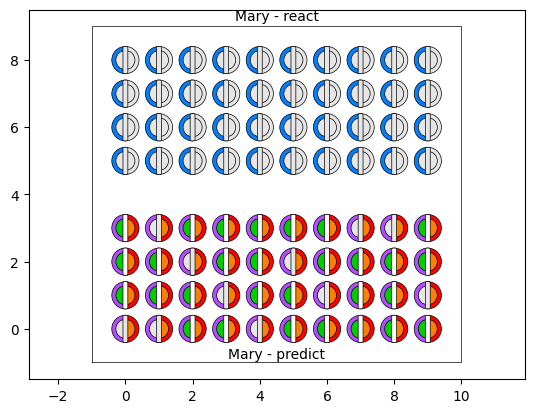

In [3]:
m = 4; n = 10
cells = Cluster(m,n,2,5).init()
c=[0 for k in range(m*n)]; f = token['Mary']; y = c + f
y = cells.apply(y,'Mary')


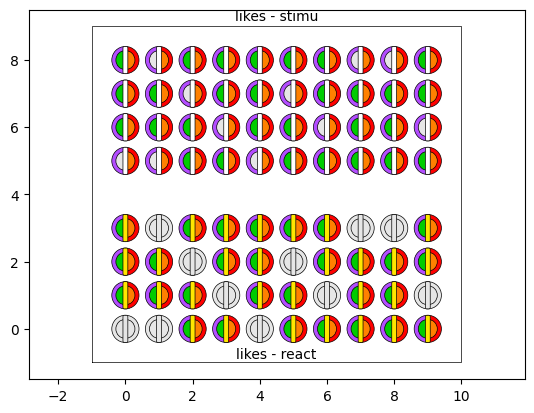

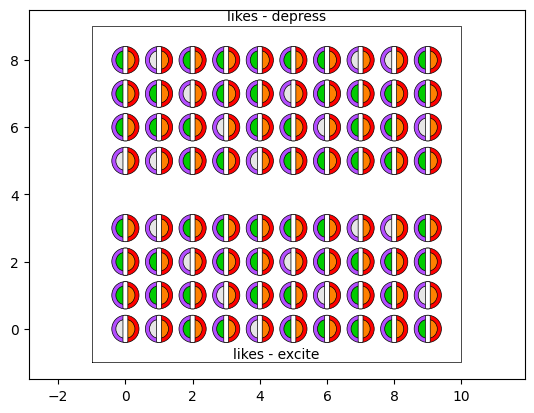

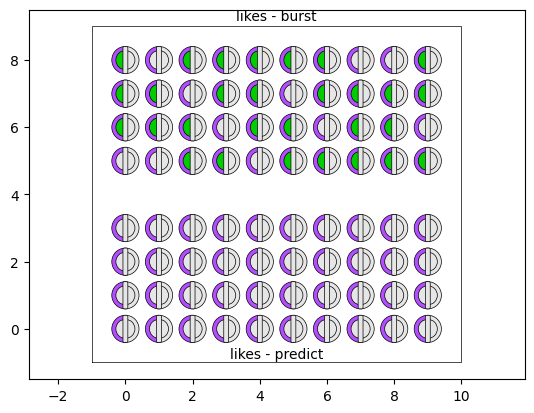

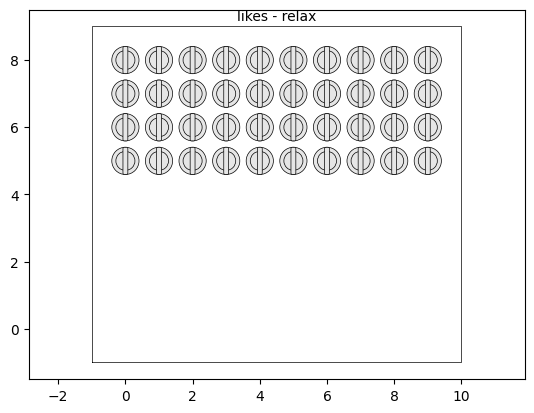

In [4]:
c=[0 for k in range(m*n)]; f = token['likes']; y = c + f
y = cells.apply(y,'likes',all=True)



In [5]:
yy=Matrix(y);yy
cdx=Matrix(range(m*n));cdx
fdx=m*n+Matrix(range(len(f)));fdx

[40 41 42 43 44 45 46 47]

In [6]:
from numpy import ndarray,array, transpose
from carabao.neurotron import Monitor
from carabao.matrix import Attribute, Matrix, Field, rand, sum, zeros
from carabao.util import repr

y = Matrix(range(5,15));print(y)
idx=Matrix(range(3));print(idx)
y[idx]=80+idx; print(y)

[5 6 7 8 9 10 11 12 13 14]
[0 1 2]
[80 81 82 8 9 10 11 12 13 14]


In [9]:
Matrix(idx)

[0 1 2]